In [1]:
import pandas as pd
import numpy as np
from itertools import combinations 
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import re




# Auxiliary Functions preprocessing.

In [2]:
def filter_data(raw_data, intensity_kind):
    df = raw_data.copy()
    colomns_to_filter = df.columns[6:]
    for col_name in colomns_to_filter:
        if intensity_kind not in col_name:
            df = df.drop(col_name, 1)
    return df 

def split_by_methods(df,intensity_kind):
    epulse_df = df.copy()
    lysis_df = df.copy()
    for col_name in df.columns:
        res = re.search(intensity_kind, col_name)
        if res != None:
            res = re.search(f'C', col_name)
            if res == None:  
                lysis_df = lysis_df.drop(col_name, 1)
            else:
                epulse_df = epulse_df.drop(col_name, 1)
    return epulse_df, lysis_df

def binarize_intensity(df, start=6):
    df.iloc[:,start:] = df.iloc[:,start:].clip_upper(1)
    return df

# Read Merged Lysis Dataset.

In [3]:
df_lysis = pd.read_excel('RNA-HADAS-FIXED-NAMES.xlsx').fillna(0)

In [4]:
df_lysis.rename(columns = {'Unnamed: 0':'Gene names'}, inplace = True)

In [5]:
df_lysis.rename(columns = {col:col.replace('_lysis','L').replace('_C','_') for col in df_lysis.loc[:,'BCC Intensity 12_C1_lysis':].columns}, inplace = True)

In [6]:
df_lysis

,Gene names,BCC Intensity 12_1L,BCC Intensity 12_3L,BCC Intensity 12_5L,BCC Intensity 27_1L,BCC Intensity 27_3L,BCC Intensity 27_5L,BCC Intensity 39_1L,BCC Intensity 39_3L,BCC Intensity 39_5L
0,ENSG00000223972,0,1,0,0,0,0,0,0,0
1,ENSG00000227232,6,46,6,69,30,42,12,41,13
2,ENSG00000278267,13,9,1,13,8,1,4,8,2
3,ENSG00000243485,0,0,0,1,3,1,0,1,0
4,ENSG00000238009,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
49470,ENSG00000276312,0,0,0,0,0,1,0,0,0
49471,ENSG00000275757,1,27,19,60,19,11,43,13,5
49472,ENSG00000278817,4,19,2,19,11,13,5,16,3
49473,ENSG00000277196,2,4,2,76,43,25,6,29,9


# Binarize Intensities

In [7]:
binary_df_lysis = binarize_intensity(df_lysis, start=1)
binary_df_lysis

/Users/ilaigenishmac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead


,Gene names,BCC Intensity 12_1L,BCC Intensity 12_3L,BCC Intensity 12_5L,BCC Intensity 27_1L,BCC Intensity 27_3L,BCC Intensity 27_5L,BCC Intensity 39_1L,BCC Intensity 39_3L,BCC Intensity 39_5L
0,ENSG00000223972,0,1,0,0,0,0,0,0,0
1,ENSG00000227232,1,1,1,1,1,1,1,1,1
2,ENSG00000278267,1,1,1,1,1,1,1,1,1
3,ENSG00000243485,0,0,0,1,1,1,0,1,0
4,ENSG00000238009,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
49470,ENSG00000276312,0,0,0,0,0,1,0,0,0
49471,ENSG00000275757,1,1,1,1,1,1,1,1,1
49472,ENSG00000278817,1,1,1,1,1,1,1,1,1
49473,ENSG00000277196,1,1,1,1,1,1,1,1,1


# Add BCC kind as prefix to each column.

In [8]:
infiltrative_bcc3 = [i for i in binary_df_lysis.columns if i.startswith('BCC') and any(x in i for x in ['39'])]
superficial_bcc3 = [i for i in binary_df_lysis.columns if i.startswith('BCC') and any(x in i for x in ['12'])]
nodular_bcc3 = [i for i in binary_df_lysis.columns if i.startswith('BCC') and any(x in i for x in ['27'])]
bcc3 = []
bcc3.extend(infiltrative_bcc3)
bcc3.extend(superficial_bcc3)
bcc3.extend(nodular_bcc3)
df_bcc3 = binary_df_lysis[bcc3]
# display(df_BCC3)
df_bcc3.columns = ['{0}{1}'.format('Infiltrative ' if c in infiltrative_bcc3 else 'Superficial ' if c in superficial_bcc3 else 'Nodular ',c) for c in bcc3]
display(df_bcc3)


,Infiltrative BCC Intensity 39_1L,Infiltrative BCC Intensity 39_3L,Infiltrative BCC Intensity 39_5L,Superficial BCC Intensity 12_1L,Superficial BCC Intensity 12_3L,Superficial BCC Intensity 12_5L,Nodular BCC Intensity 27_1L,Nodular BCC Intensity 27_3L,Nodular BCC Intensity 27_5L
0,0,0,0,0,1,0,0,0,0
1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1
3,0,1,0,0,0,0,1,1,1
4,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
49470,0,0,0,0,0,0,0,0,1
49471,1,1,1,1,1,1,1,1,1
49472,1,1,1,1,1,1,1,1,1
49473,1,1,1,1,1,1,1,1,1


In [9]:
infiltrative_bcc3

['BCC Intensity 39_1L', 'BCC Intensity 39_3L', 'BCC Intensity 39_5L']

In [10]:
new_columns = []
for col in df_bcc3.columns[:]:
    new_col = col.replace("Infiltrative", "I_")
    new_col = new_col.replace("Superficial", "S_")
    new_col = new_col.replace("Nodular", "N_")
    new_col = new_col.replace("1L", "I")
    new_col = new_col.replace("3L", "II")
    new_col = new_col.replace("5L", "III")
    new_col = new_col.replace("39", "1")
    new_col = new_col.replace("12", "4")    
    new_col = new_col.replace("27", "7")
    new_col = new_col.replace(" BCC Intensity ", "").strip()
    #new_col += ' '
    #new_col = new_col.replace(" ", "")
    new_columns.append(new_col)
df_bcc3.columns = new_columns    
display(df_bcc3)
df_bcc3['I_1_I']

,I_1_I,I_1_II,I_1_III,S_4_I,S_4_II,S_4_III,N_7_I,N_7_II,N_7_III
0,0,0,0,0,1,0,0,0,0
1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1
3,0,1,0,0,0,0,1,1,1
4,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
49470,0,0,0,0,0,0,0,0,1
49471,1,1,1,1,1,1,1,1,1
49472,1,1,1,1,1,1,1,1,1
49473,1,1,1,1,1,1,1,1,1


0        0
1        1
2        1
3        0
4        0
        ..
49470    0
49471    1
49472    1
49473    1
49474    0
Name: I_1_I, Length: 49475, dtype: int64

# Auxiliary Functions Drawing.

In [11]:
def draw_tree(tree):
    fig = plt.figure(figsize=(40,40), dpi=100)
    matplotlib.rc('font', size=37)
    axes = fig.add_subplot(1, 1, 1)
    Phylo.draw(tree, axes=axes, branch_labels=lambda c: c.branch_length)
    plt.rcParams['lines.linewidth'] = 6
    
def draw_cancers_coloring_tree(tree):
    infiltrative = [{"name": r"I_1_I"}, {"name": r"I_1_II"}, {"name": r"I_1_III"}]
    
    superficial =  [{"name": r"S_4_I"}, {"name": r"S_4_II"}, {"name": r"S_4_III"}]
    
    nodular =   [{"name": r"N_7_I"}, {"name": r"N_7_II"}, {"name": r"N_7_III"}]
    
   
    for patients, color in [(infiltrative,'#BA55D3'), (superficial,'#FF8C00'), (nodular,'blue')]:
        for patient in patients:
            try:
#             mrca = tree.is_monophyletic([patient['name']])
                mrca = tree.common_ancestor([patient])
                print(mrca)
                mrca.color = color
            except:
                print('a')
    draw_tree(tree)
    
    
from io import StringIO
from Bio import Phylo

# Auxiliary Functions Local Intersection Tree Building.

In [12]:
def get_node_data(n,df_bcc3):
    sample = df_bcc3[n]
    rest = df_bcc3.drop(n,1)
    vector = [1 if sample[i] == 1 else 0 for i in sample.index]
    return vector
    
def calc_intersection(branch1_vector,branch2_vector, root_vector):
    return sum([1 if branch1_vector[i]==branch2_vector[i]==1 else 0 for i in range(len(branch1_vector))]) - sum(root_vector)

def add_row_to_table(branch1_vector,branch2_vector,branch3_vector,table,root_vector):
    print('aaaaaaa', len(branch1_vector),len(branch2_vector),len(branch3_vector),len(root_vector))
    n1_sub_vector = [1 if branch1_vector[i]==branch2_vector[i]==1 or branch3_vector[i]==branch1_vector[i]==1 else 0 for i in range(len(root_vector))]
    n2_sub_vector = [1 if branch1_vector[i]==branch2_vector[i]==1 or branch3_vector[i]==branch2_vector[i]==1 else 0 for i in range(len(root_vector))]
    n3_sub_vector = [1 if branch3_vector[i]==branch2_vector[i]==1 or branch3_vector[i]==branch1_vector[i]==1 else 0 for i in range(len(root_vector))]
    
    table.append({'L I UG':sum(branch1_vector)-sum(n1_sub_vector),
                  'L II UG':sum(branch2_vector)-sum(n2_sub_vector),
                  'L III UG':sum(branch3_vector)-sum(n3_sub_vector),
                  'L I and L II CG':calc_intersection(branch1_vector, branch2_vector,root_vector),
                  'L I and L III CG':calc_intersection(branch1_vector, branch3_vector,root_vector),
                  'L II and L III CG':calc_intersection(branch2_vector, branch3_vector,root_vector)})
    return table

def get_nodes_hierarchy(n1,n2,n3,df,table, kind='regular'):
    tree = ''
    vector1 = get_node_data(n1, df_bcc3)
    vector2 = get_node_data(n2, df_bcc3)
    vector3 = get_node_data(n3, df_bcc3)

    samples = df_bcc3[[n1, n2, n3]]
    rest = df_bcc3.drop([n1, n2, n3],1)
    root_vector = [1 if vector1[i]==vector2[i]==vector3[i]==1 else 0 for i in df_bcc3.index]
    #remove
    if kind == 'regular':
        n1_sub_vector = root_vector
        n2_sub_vector = root_vector
        n3_sub_vector = root_vector
    if kind == 'complement':
        n1_sub_vector = [1 if vector1[i]==vector2[i]==1 or vector3[i]==vector1[i]==1 else 0 for i in samples.index]
        n2_sub_vector = [1 if vector1[i]==vector2[i]==1 or vector3[i]==vector2[i]==1 else 0 for i in samples.index]
        n3_sub_vector = [1 if vector3[i]==vector2[i]==1 or vector3[i]==vector1[i]==1 else 0 for i in samples.index]
    display('rest',rest)
    display('root_vector', root_vector)
    root_distance = int(sum(root_vector))
    hierarchy = '({}, {}, {}){}'.format(n1.replace('BCC ','').replace('intensity ', '').replace('Intensity ', '').replace(' ','_') + ':' + str(int(sum(vector1)-sum(n1_sub_vector))),
                                        n2.replace('BCC ','').replace('intensity ', '').replace('Intensity ', '').replace(' ','_') + ':' + str(int(sum(vector2)-sum(n2_sub_vector))),
                                        n3.replace('BCC ','').replace('intensity ', '').replace('Intensity ', '').replace(' ','_') + ':' + str(int(sum(vector3)-sum(n3_sub_vector))),
                                       ':' + str(root_distance))
    
    table = add_row_to_table(vector1, vector2, vector3, table, root_vector)

    return hierarchy, root_vector,table




def join_triplet_tree(tree_data1, tree_data2, tree_data3, tree_vector1, tree_vector2, tree_vector3, df_bcc3, bcc_kind, table, kind='regular'):
    if bcc_kind == '':
        bcc_kind_names = binary_df_lysis.columns[binary_df_lysis.columns.str.startswith('BCC')]
        rest = binary_df_lysis.iloc[:,1:].drop(bcc_kind_names,1)
        display(rest)
        root_vector = [1 if df_bcc3.iloc[i,:].sum()==df_bcc3.shape[1] else 0 for i in df_bcc3.index]
    else:    
        bcc_kind_names = df_bcc3.columns[df_bcc3.columns.str.startswith(bcc_kind)]
        print(bcc_kind_names,'\n\n\n')
        rest = df_bcc3.drop(bcc_kind_names,1)
        bcc_kind_df = df_bcc3[bcc_kind_names]
        root_vector = [1 if bcc_kind_df.iloc[i,:].sum() == bcc_kind_df.shape[1] else 0 for i in bcc_kind_df.index]
    
    if kind == 'regular':
        tree1_sub_vector = root_vector
        tree2_sub_vector = root_vector
        tree3_sub_vector = root_vector
    if kind == 'complement':
        tree1_sub_vector = [1 if tree_vector1[i]==tree_vector2[i]==1 or tree_vector3[i]==tree_vector1[i]==1 else 0 for i in df_bcc3.index]
        tree2_sub_vector = [1 if tree_vector1[i]==tree_vector2[i]==1 or tree_vector3[i]==tree_vector2[i]==1 else 0 for i in df_bcc3.index]
        tree3_sub_vector = [1 if tree_vector3[i]==tree_vector2[i]==1 or tree_vector3[i]==tree_vector1[i]==1 else 0 for i in df_bcc3.index]
    
    table = add_row_to_table(tree_vector1, tree_vector2, tree_vector3, table, root_vector)    
    tree_data1 = re.sub(r'[0-9]+$', str(int(sum(tree_vector1)-sum(tree1_sub_vector))), tree_data1)            
    tree_data2 = re.sub(r'[0-9]+$', str(int(sum(tree_vector2)-sum(tree2_sub_vector))), tree_data2)            
    tree_data3 = re.sub(r'[0-9]+$', str(int(sum(tree_vector3)-sum(tree3_sub_vector))), tree_data3)            
    final_tree = '({},{},{}){}'.format(tree_data1,
                                       tree_data2,
                                       tree_data3,
                                      ':'+ str(sum(root_vector)))
    return final_tree, root_vector,table


In [13]:
infiltrative =[('Infiltrative BCC Intensity 39_1L', 'Infiltrative BCC Intensity 39_3L', 'Infiltrative BCC Intensity 39_5L')]

superficial =[('Superficial BCC Intensity 12_1L', 'Superficial BCC Intensity 12_3L', 'Superficial BCC Intensity 12_5L')]

nodular =[('Nodular BCC Intensity 27_1L', 'Nodular BCC Intensity 27_3L', 'Nodular BCC Intensity 27_5L')]


In [14]:
def build_LI_BCC_tree(df_bcc3, kind='regular'):
    table = []
    tree_data_39,tree_vector_39,table = get_nodes_hierarchy('I_1_I', 
                                                      'I_1_II', 
                                                      'I_1_III',
                                                      df_bcc3,table,kind=kind)

    tree_data_12, tree_vector_12,table = get_nodes_hierarchy('S_4_I', 
                                                       'S_4_II', 
                                                       'S_4_III',
                                                       df_bcc3,table, kind=kind)

    tree_data_27,tree_vector_27,table = get_nodes_hierarchy('N_7_I', 
                                                      'N_7_II', 
                                                      'N_7_III',
                                                      df_bcc3,table,  kind=kind)

    final_tree, final_vector, table = join_triplet_tree(tree_data_39, tree_data_12, tree_data_27, tree_vector_39, tree_vector_12, tree_vector_12,df_bcc3,'', table, kind=kind)
    return final_tree, final_vector, table


# Create LocaI Intersection BCC Tree.

In [15]:
final_tree, final_vector, table = build_LI_BCC_tree(df_bcc3,kind= 'regular')
df = pd.DataFrame(table, index = np.arange(1,len(table)+1))


'rest'

,S_4_I,S_4_II,S_4_III,N_7_I,N_7_II,N_7_III
0,0,1,0,0,0,0
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,0,0,0,1,1,1
4,0,0,1,0,0,0
...,...,...,...,...,...,...
49470,0,0,0,0,0,1
49471,1,1,1,1,1,1
49472,1,1,1,1,1,1
49473,1,1,1,1,1,1


'root_vector'

[0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,


aaaaaaa 49475 49475 49475 49475


'rest'

,I_1_I,I_1_II,I_1_III,N_7_I,N_7_II,N_7_III
0,0,0,0,0,0,0
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,0,1,0,1,1,1
4,0,0,1,0,0,0
...,...,...,...,...,...,...
49470,0,0,0,0,0,1
49471,1,1,1,1,1,1
49472,1,1,1,1,1,1
49473,1,1,1,1,1,1


'root_vector'

[0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,


aaaaaaa 49475 49475 49475 49475


'rest'

,I_1_I,I_1_II,I_1_III,S_4_I,S_4_II,S_4_III
0,0,0,0,0,1,0
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,0,1,0,0,0,0
4,0,0,1,0,0,1
...,...,...,...,...,...,...
49470,0,0,0,0,0,0
49471,1,1,1,1,1,1
49472,1,1,1,1,1,1
49473,1,1,1,1,1,1


'root_vector'

[0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,


aaaaaaa 49475 49475 49475 49475


""
0
1
2
3
4
...
49470
49471
49472
49473


aaaaaaa 49475 49475 49475 49475


In [16]:
df_lysis

,Gene names,BCC Intensity 12_1L,BCC Intensity 12_3L,BCC Intensity 12_5L,BCC Intensity 27_1L,BCC Intensity 27_3L,BCC Intensity 27_5L,BCC Intensity 39_1L,BCC Intensity 39_3L,BCC Intensity 39_5L
0,ENSG00000223972,0,1,0,0,0,0,0,0,0
1,ENSG00000227232,1,1,1,1,1,1,1,1,1
2,ENSG00000278267,1,1,1,1,1,1,1,1,1
3,ENSG00000243485,0,0,0,1,1,1,0,1,0
4,ENSG00000238009,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
49470,ENSG00000276312,0,0,0,0,0,1,0,0,0
49471,ENSG00000275757,1,1,1,1,1,1,1,1,1
49472,ENSG00000278817,1,1,1,1,1,1,1,1,1
49473,ENSG00000277196,1,1,1,1,1,1,1,1,1


In [17]:
df = pd.DataFrame(table, index = ['A','B','C','D'])
display(df)

final_tree

,L I UG,L II UG,L III UG,L I and L II CG,L I and L III CG,L II and L III CG
A,1818,3849,933,3888,752,1873
B,1299,3721,1867,2235,810,2650
C,3544,1201,1497,2574,2146,674
D,7185,0,0,726,726,2093


'((I_1_I:6458, I_1_II:9610, I_1_III:3558):7911,(S_4_I:4344, S_4_II:8606, S_4_III:5327):2093,(N_7_I:8264, N_7_II:4449, N_7_III:4317):2093):20115'

I_1_I
I_1_II
I_1_III
S_4_I
S_4_II
S_4_III
N_7_I
N_7_II
N_7_III


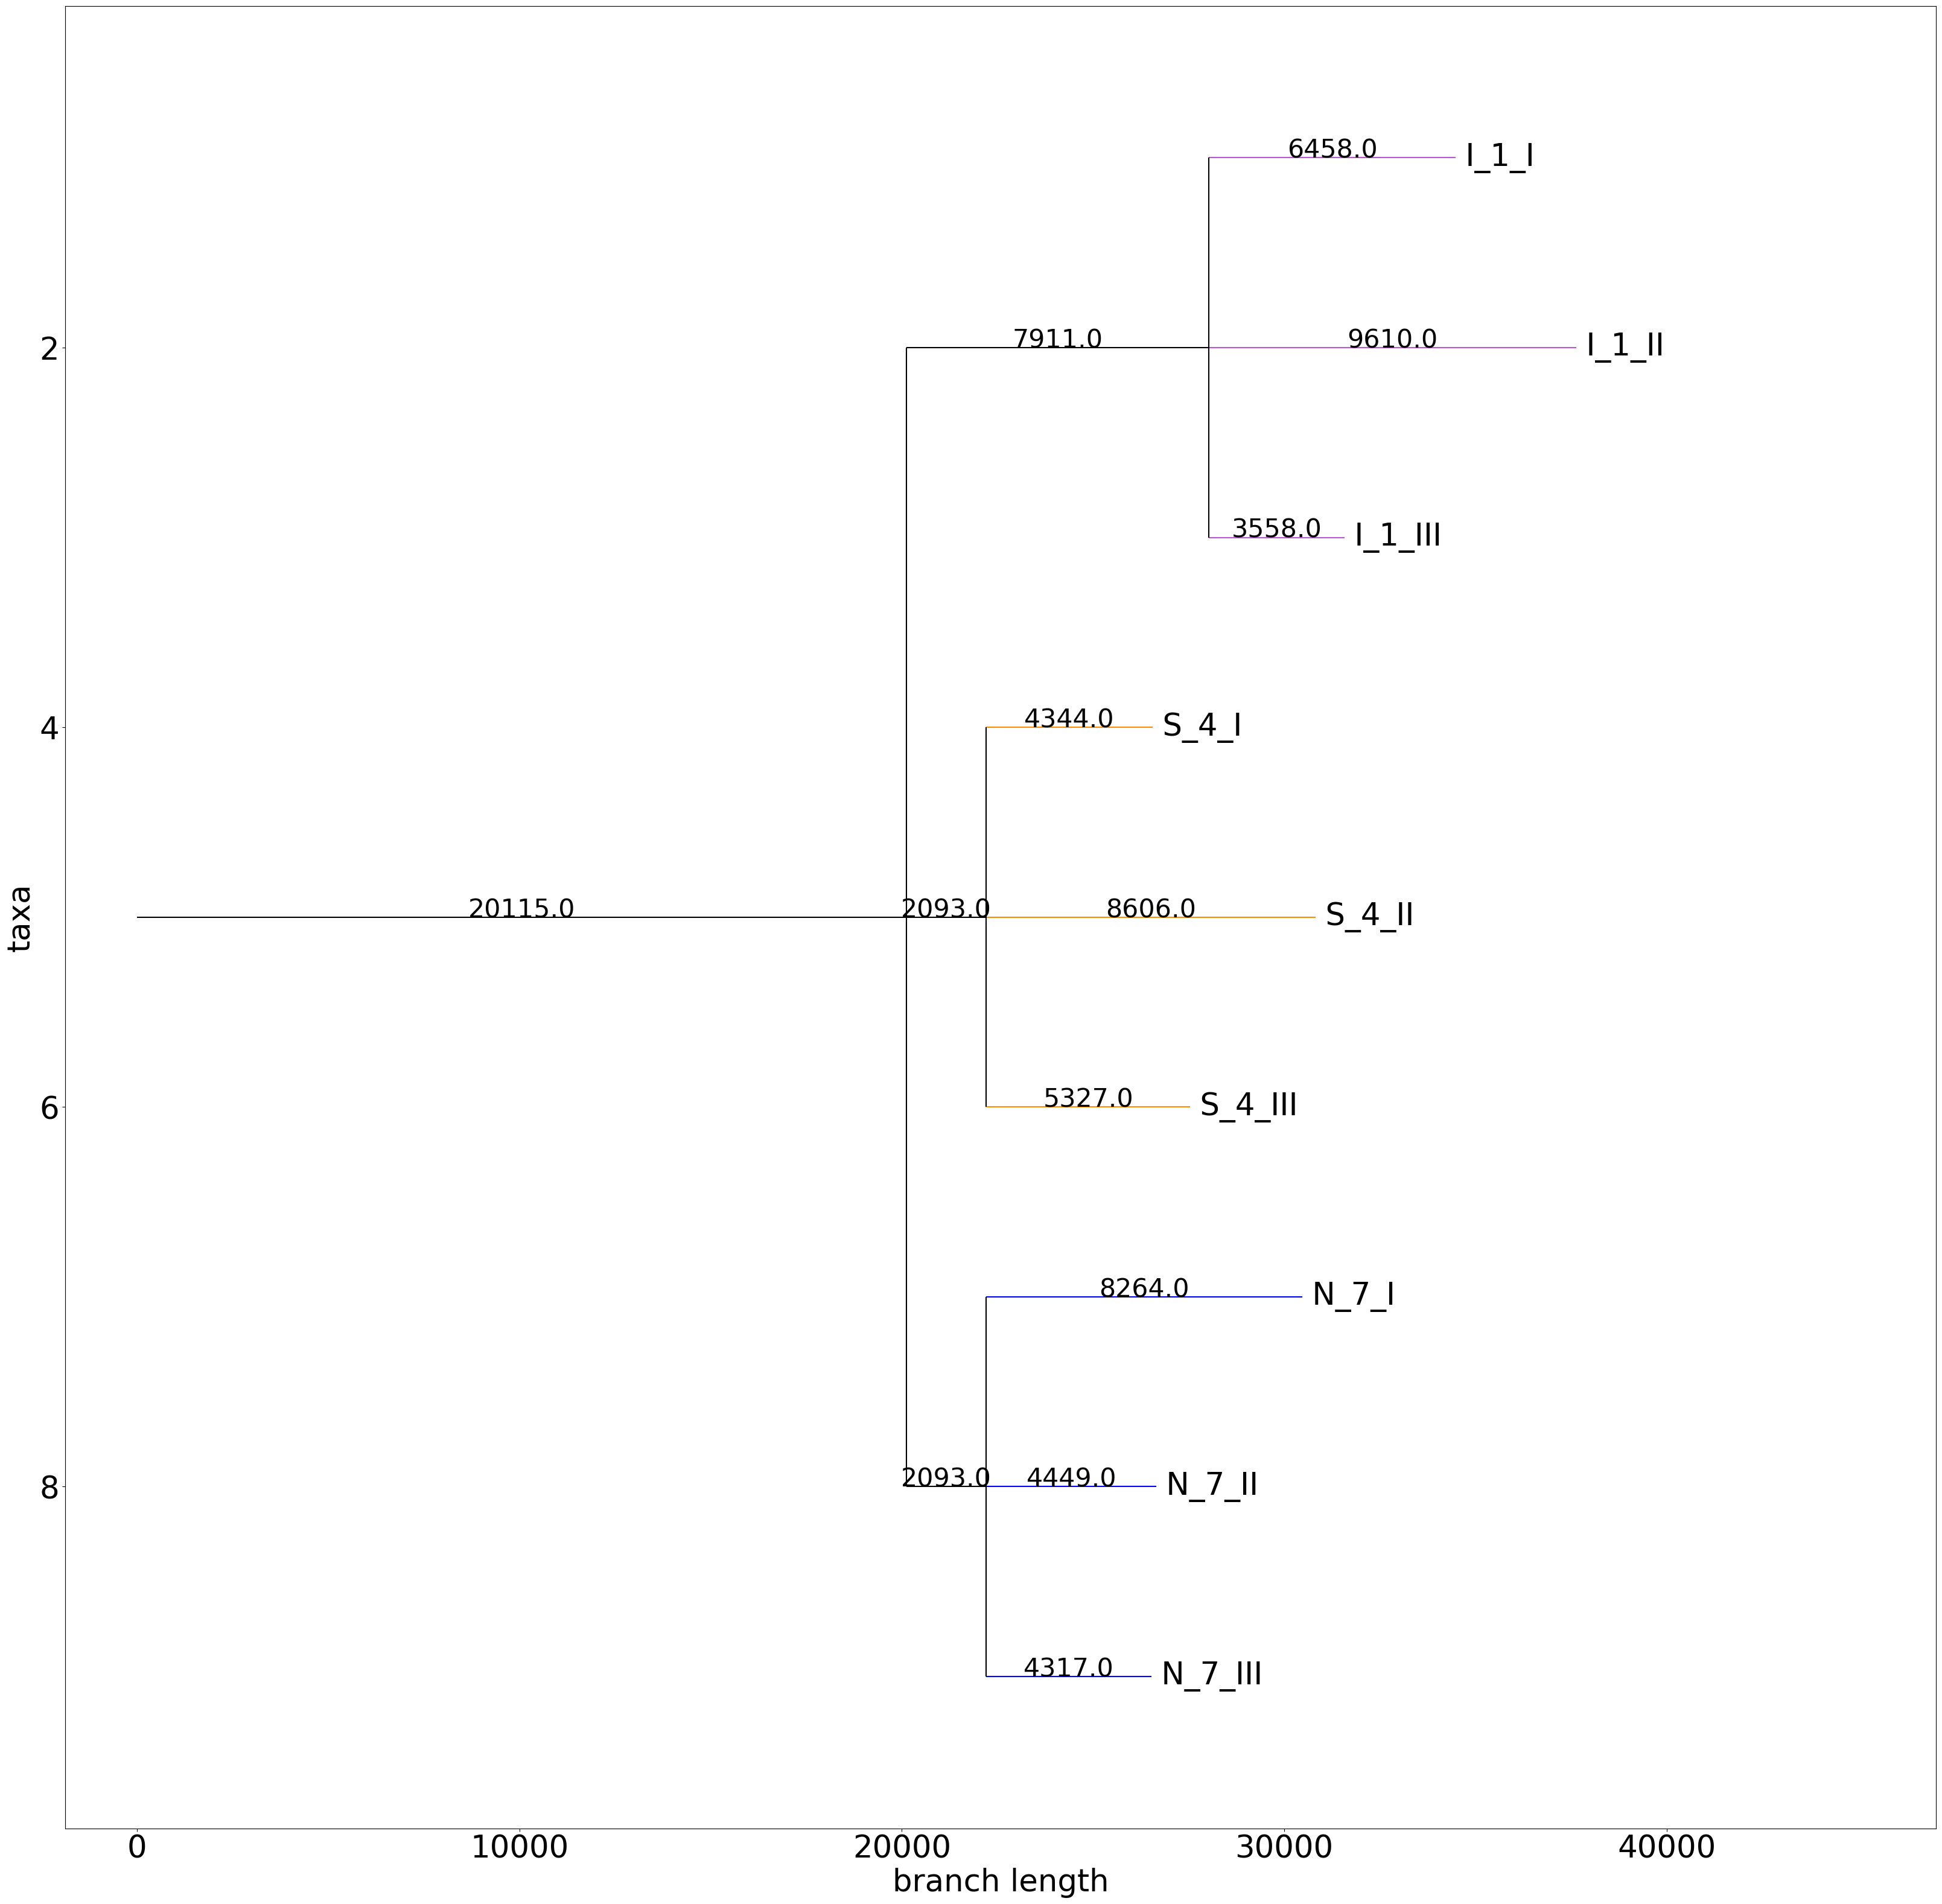

In [18]:
handle = StringIO(final_tree)            
tree = Phylo.read(handle, "newick", )
Phylo.write(tree, 'BCC-SUBTYPES-TREE' + '.dnd', "newick", format_branch_length='%i')

tree_data = Phylo.read('BCC-SUBTYPES-TREE.dnd',"newick")
draw_cancers_coloring_tree(tree_data)



In [19]:
df_bcc3

,I_1_I,I_1_II,I_1_III,S_4_I,S_4_II,S_4_III,N_7_I,N_7_II,N_7_III
0,0,0,0,0,1,0,0,0,0
1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1
3,0,1,0,0,0,0,1,1,1
4,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
49470,0,0,0,0,0,0,0,0,1
49471,1,1,1,1,1,1,1,1,1
49472,1,1,1,1,1,1,1,1,1
49473,1,1,1,1,1,1,1,1,1


In [20]:
# sample = df_bcc3['Infiltrative BCC Intensity 39_5L']
# rest = df_bcc3[['Infiltrative BCC Intensity 39_1L','Infiltrative BCC Intensity 39_3L']]
# # display(rest.sum(1))
# sum(1 for i in sample.index if sample.iloc[i]==1 and rest.iloc[i,:].sum()==0 )

# Create LocaI Intersection BCC Complement Tree.

In [21]:
final_tree, final_vector, table = build_LI_BCC_tree(df_bcc3,kind= 'complement')
df = pd.DataFrame(table, index = ['A','B','C','D'])
display(df)


'rest'

,S_4_I,S_4_II,S_4_III,N_7_I,N_7_II,N_7_III
0,0,1,0,0,0,0
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,0,0,0,1,1,1
4,0,0,1,0,0,0
...,...,...,...,...,...,...
49470,0,0,0,0,0,1
49471,1,1,1,1,1,1
49472,1,1,1,1,1,1
49473,1,1,1,1,1,1


'root_vector'

[0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,


aaaaaaa 49475 49475 49475 49475


'rest'

,I_1_I,I_1_II,I_1_III,N_7_I,N_7_II,N_7_III
0,0,0,0,0,0,0
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,0,1,0,1,1,1
4,0,0,1,0,0,0
...,...,...,...,...,...,...
49470,0,0,0,0,0,1
49471,1,1,1,1,1,1
49472,1,1,1,1,1,1
49473,1,1,1,1,1,1


'root_vector'

[0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,


aaaaaaa 49475 49475 49475 49475


'rest'

,I_1_I,I_1_II,I_1_III,S_4_I,S_4_II,S_4_III
0,0,0,0,0,1,0
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,0,1,0,0,0,0
4,0,0,1,0,0,1
...,...,...,...,...,...,...
49470,0,0,0,0,0,0
49471,1,1,1,1,1,1
49472,1,1,1,1,1,1
49473,1,1,1,1,1,1


'root_vector'

[0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,


aaaaaaa 49475 49475 49475 49475


""
0
1
2
3
4
...
49470
49471
49472
49473


aaaaaaa 49475 49475 49475 49475


,L I UG,L II UG,L III UG,L I and L II CG,L I and L III CG,L II and L III CG
A,1818,3849,933,3888,752,1873
B,1299,3721,1867,2235,810,2650
C,3544,1201,1497,2574,2146,674
D,7185,0,0,726,726,2093


I_1_I
I_1_II
I_1_III
S_4_I
S_4_II
S_4_III
N_7_I
N_7_II
N_7_III


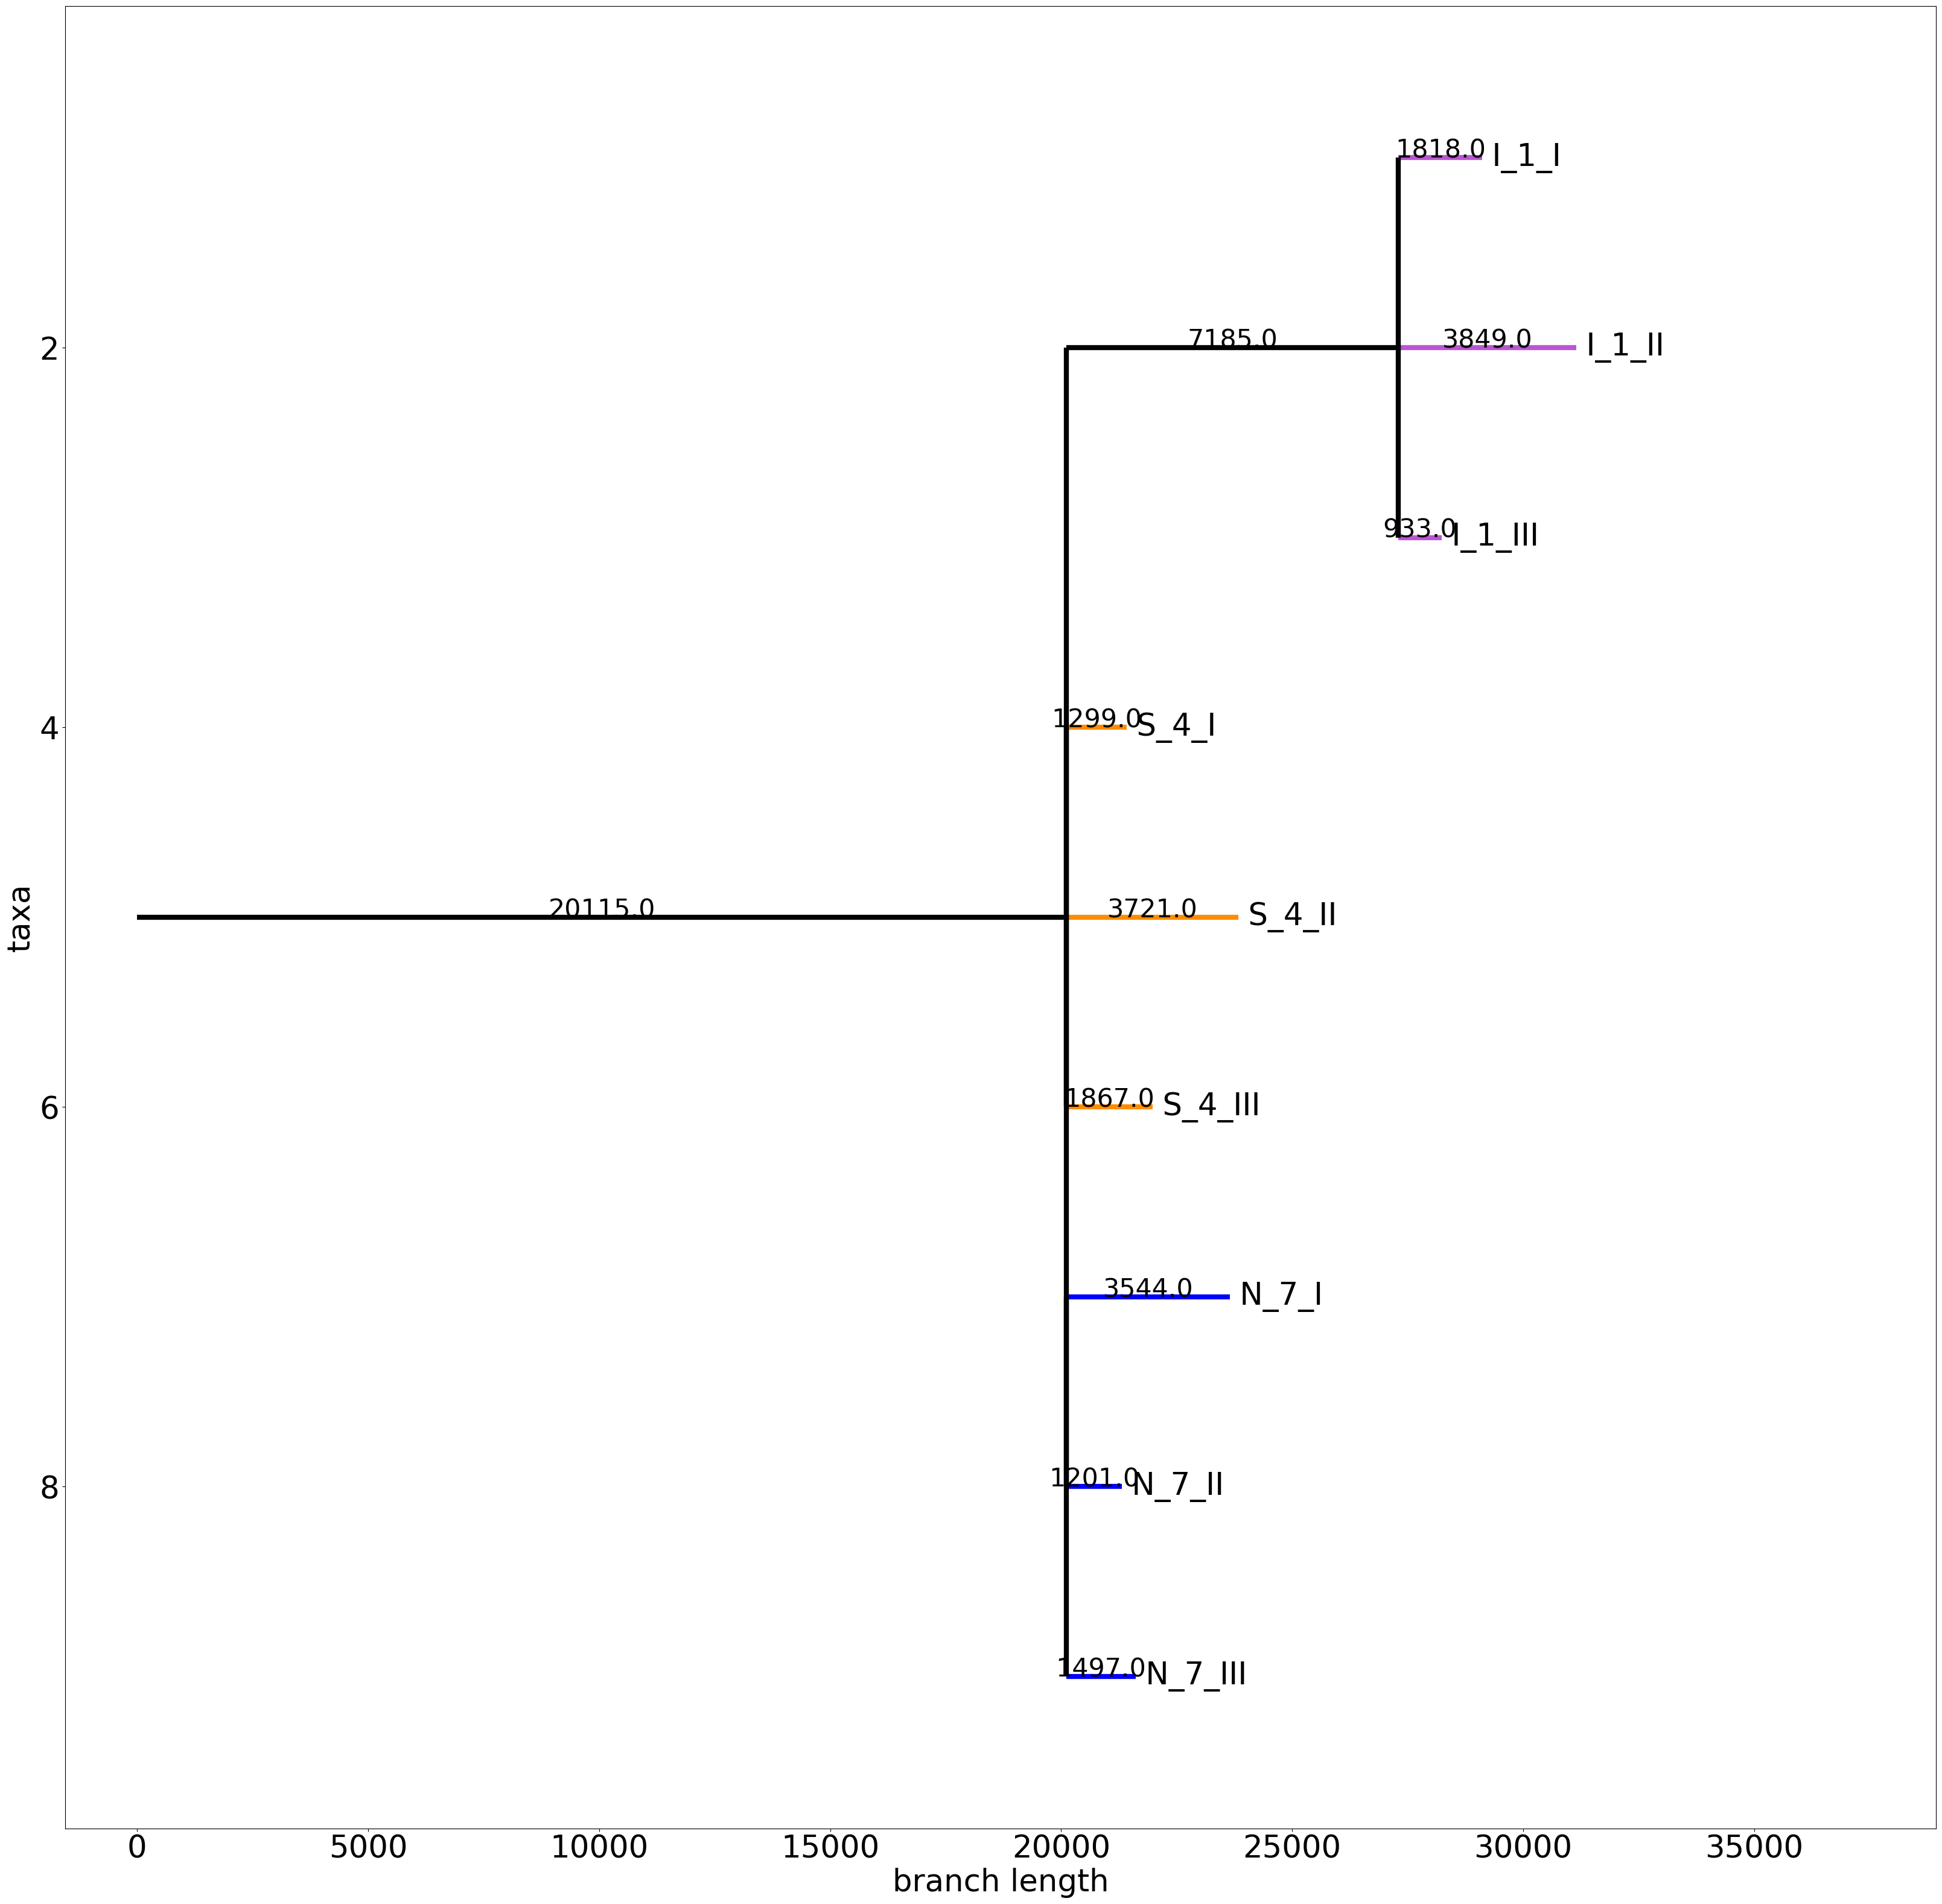

In [22]:
handle = StringIO(final_tree)            
tree = Phylo.read(handle, "newick")
Phylo.write(tree, 'BCC-SUBTYPES-TREE-COMPLEMENT' + '.dnd', "newick")

tree_data = Phylo.read('BCC-SUBTYPES-TREE-COMPLEMENT.dnd',"newick")
draw_cancers_coloring_tree(tree_data)

